In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import ast
import scipy
import mdtraj as md
from typing import Dict, Tuple
import os
from sklearn.linear_model import LinearRegression
import sys
from scipy.optimize import fsolve
bme_dir = '/projects/lindorff_group/people/thd711/HDX_project/code/BME/' # replace this with your local copy of the BME code
sys.path.append(bme_dir)
import BME as BME
import pyblock
import gzip
import pickle

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 150,                   # medium resolution

    # Axes
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def find_xtc_filenames(path_to_dir, suffix=".xtc"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

# --- Utility functions ---
def RMSE(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.sqrt(np.mean((actual - predicted)**2))

# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# functions for analysis of chemical shifts
# functions for chemical shift analysis
# Constants
# from here : https://link.springer.com/article/10.1007/s10858-010-9433-9 (average prediction error of the forward model)
CS_UNCERTAINTIES = {
    "Sparta+": {"C": 1.09, "CA": 0.94, "CB": 1.14, "N": 2.45, "H": 0.49, "HA": 0.25}
}

POTENCI_UNCERTAINTIES = {"C": 0.1861, "CA": 0.1862, "CB": 0.1677, "N": 0.5341, "H": 0.0735, "HA": 0.0319, "HB": 0.0187}

AA_dict = {
    "A": "ALA",  # Alanine
    "R": "ARG",  # Arginine
    "N": "ASN",  # Asparagine
    "D": "ASP",  # Aspartic Acid
    "C": "CYS",  # Cysteine
    "E": "GLU",  # Glutamic Acid
    "Q": "GLN",  # Glutamine
    "G": "GLY",  # Glycine
    "H": "HIS",  # Histidine
    "I": "ILE",  # Isoleucine
    "L": "LEU",  # Leucine
    "K": "LYS",  # Lysine
    "M": "MET",  # Methionine
    "F": "PHE",  # Phenylalanine
    "P": "PRO",  # Proline
    "S": "SER",  # Serine
    "T": "THR",  # Threonine
    "W": "TRP",  # Tryptophan
    "Y": "TYR",  # Tyrosine
    "V": "VAL",  # Valine
}

# atom types to use during reweighting: choose from [ HA CA HN N C CB ]
ATOM_TYPES = ["CA", "HA", "CB", "HN", "N", "C", "H"] # HN and H present because "H" is used in potenci shift tables
ATOM_TYPES = ["CA"] 

def load_experimental_shifts(path: str, ATOM_TYPES) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#RESID'][i])
        for col in df.columns[2:]:
            if col in ATOM_TYPES: # only including specified nuclei
                if col=='HN':
                    try:
                        value = float(df[col][i])
                        if value>0:
                            residues.append(res)
                            names.append('H') # rename HN to H
                            values.append(value)
                    except:
                        continue
                else:
                    try:
                        value = float(df[col][i])
                        if value>0:
                            residues.append(res)
                            names.append(col)
                            values.append(value)
                    except:
                        continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_and_filter_experimental_shifts(path: str, bmrb_stats_path: str, sigma_cutoff = 3.0, ATOM_TYPES = ATOM_TYPES) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    bmrb = pd.read_csv(bmrb_stats_path)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#RESID'][i])
        resname = str(df['RESNAME'][i])
        if len(resname)==1:
            resname = AA_dict[resname] # convert to 3-letter code if 1-letter
        for col in df.columns[2:]:
            if col in ATOM_TYPES: # only including specified nuclei
                try:
                    value = float(df[col][i])
                    if value>0:
                        # extract bmrb avg and sd
                        if col=='HN':
                            row = bmrb[(bmrb["comp_id"] == resname) & (bmrb["atom_id"] == 'H')]
                            bmrb_mu = row["avg"].values[0]
                            bmrb_sd = row["std"].values[0]
                            if np.abs(value - bmrb_mu) < bmrb_sd * sigma_cutoff:
                                residues.append(res)
                                names.append('H') # rename HN to H
                                values.append(value)
                        else:
                            row = bmrb[(bmrb["comp_id"] == resname) & (bmrb["atom_id"] == col)]
                            bmrb_mu = row["avg"].values[0]
                            bmrb_sd = row["std"].values[0]
                            if np.abs(value - bmrb_mu) < bmrb_sd * sigma_cutoff:
                                residues.append(res)
                                names.append(col)
                                values.append(value)
                except:
                    continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_potenci_shifts(path: str, ATOM_TYPES = ATOM_TYPES) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#NUM'][i])
        for col in df.columns[2:]:
            if col in ATOM_TYPES: # only including specified nuclei
                try:
                    value = float(df[col][i])
                    if value>0:
                        residues.append(res)
                        names.append(col)
                        values.append(value)
                except:
                    continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_generated_shifts(path: str) -> pd.DataFrame:
    """
    Load generated shifts from a CSV file.
    Assumes columns: resSeq, name, 0, 1, 2, ..., representing one residue/atom per row and frames across columns.
    Returns DataFrame indexed by (resSeq, name), with frames as columns.
    """
    df = pd.read_csv(path)
    df["resSeq"] = df["resSeq"].astype(int)
    df["name"] = df["name"].astype(str)
    df.set_index(["resSeq", "name"], inplace=True)
    return df

def standardize_deltas(gen_df: pd.DataFrame, exp_dict: Dict[Tuple[int, str], float],
                       predictor: str = "Sparta+", avg_gscore: float = None) -> Tuple[np.ndarray, list]:
    cs_uncertainties = CS_UNCERTAINTIES[predictor]
    keys = sorted(set(exp_dict).intersection(set(gen_df.index)))

    if avg_gscore is None:
        std_devs = np.array([cs_uncertainties[a] for (_, a) in keys]).reshape(-1, 1)
    else:
        std_devs = np.array([
            POTENCI_UNCERTAINTIES[a] + ( cs_uncertainties[a] - POTENCI_UNCERTAINTIES[a] ) * (1 - avg_gscore)
            for r, a in keys
        ]).reshape(-1, 1)
    
    exp_vals = np.array([exp_dict[k] for k in keys]).reshape(-1, 1)
    gen_vals = gen_df.loc[keys].values  # shape: (n_obs, n_frames)
    std_delta = (gen_vals - exp_vals) / std_devs
    return std_delta, keys, exp_vals, gen_vals, std_devs

# function to calculate the difference between experiment and simulation: CALC - EXP
def raw_diff(gen_df: pd.DataFrame, exp_dict: Dict[Tuple[int, str], float]):
    keys = sorted(set(exp_dict).intersection(set(gen_df.index)))
    exp_vals = np.array([exp_dict[k] for k in keys]).reshape(-1, 1)
    gen_vals = gen_df.loc[keys].values  # shape: (n_obs, n_frames)
    diff = gen_vals - exp_vals

    return diff, keys

def get_RMSE_cs(
    std_delta_cs: np.ndarray,  # shape (n_obs, n_samples)
    weights: np.ndarray = None,  # shape (n_samples,)
    order: int = 2,  # order of the norm
) -> float:
    """Root Mean Square Error."""
    assert len(std_delta_cs.shape) == 2
    mask_nan = ~np.isnan(std_delta_cs).any(axis=0)
    if weights is None:
        return np.linalg.norm(np.average(std_delta_cs[:, mask_nan], axis=1), ord=order) / np.power(
            len(std_delta_cs),
            1 / order,
        )
    mask_nan_weights = ~np.isnan(weights)
    if weights[mask_nan_weights & (~mask_nan)].sum() != 0:
        print("+++ WARNING: samples with NaN chemical shifts should have 0 weight")
    mask_nan = mask_nan & mask_nan_weights
    if not mask_nan.any():  # this happens if the optimization failed
        return np.nan
    return np.linalg.norm(
        np.average(std_delta_cs[:, mask_nan], weights=weights[mask_nan], axis=1),
        ord=order,
    ) / np.power(len(std_delta_cs), 1 / order)

path = '../'

# PRE functions
def find_xtc_filenames(path_to_dir, suffix=".xtc"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

def find_PRE_filenames(path_to_dir, suffix=".dat"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix) and 'PRE' in filename]

# constants for PRE calculations
k = 1.23e16 # Å^6 s^-2
tau_t = 0.1e-9 # s
delay_hsqc = 0.010 # 10 ms
delay_hmqc = 0.01086 # 10.86 ms
r2h_hsqc = 10.0 # s-1

# function to calculate PRE rates from distances
def calc_gamma2(r3, r6, angular, wh: float, tau_c: float, tau_t: float):
    s_pre = np.power(r3, 2)/r6*angular
    wh = 2*np.pi*1e6*wh
    j = lambda w : s_pre*tau_c / (1+(w*tau_c)**2) + (1-s_pre)*tau_t / (1+(w*tau_t)**2)
    return k*r6*(4*j(0) + 3*j(wh))

# function to calculate PRE intensity ratios from rates
def calc_hsqc_I(avg_gamma2, delay, r2h):

    return np.exp(-delay * avg_gamma2) * ( r2h / (r2h + avg_gamma2))

# function to calculate PRE intensity ratios from rates for HMQC experiments
def calc_hmqc_I(avg_gamma2, delay, r2h, r2mq):

    return np.exp(-delay * avg_gamma2) * ( r2h / (r2h + avg_gamma2)) * ( r2mq / (r2mq + avg_gamma2)) 

# function to numerically obtain PRE rates (gamma2) from intensities
def calc_avg_gamma2_fsolve(I, delay, r2h, guess=1.0):
    def eq(gamma):
        return np.exp(-delay * gamma) * (r2h / (r2h + gamma)) - I

    gamma_sol, = fsolve(eq, guess)
    return gamma_sol

# function to calculate RMSE for PREs
def RMSE_PRE(gen_arr, exp_arr):

    gen_arr = np.array(gen_arr)
    exp_arr = np.array(exp_arr)
    exp_arr = np.minimum(float(1.0), exp_arr) # do not penalise for experimental intensities above 1 (not physically possible)
    
    return np.sqrt(np.mean((gen_arr-exp_arr)**2))

outpath='../Ensemble_reweighting/rest2_rew_cs_pre/'
data_path = '../Ensemble_reweighting/'


In [2]:
protein = 'ACTR_REST2_300K_ensemble'
traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load CS data
all_types = ['CA', 'CB', 'HA', 'C', 'HN', 'H', 'N']
for i in range(len(traj_names)):
    if i==0:
        gen_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
    else:
        tmp_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
        gen_df= pd.concat([gen_df, tmp_df], axis=1, join = 'outer', ignore_index=True)

# experimental CS data
exp_dict = load_and_filter_experimental_shifts(data_path+f'./exp_data_ACTR/CS.dat', data_path+'./exp_data_ACTR/cs_stat_aa_filt.csv', ATOM_TYPES=all_types)

# average gscore for CS error scaling
gscores = np.array(pd.read_csv(data_path+'exp_data_ACTR/ACTR_adopt2_gscores.csv')['g_score'])
avg_gscore = np.mean(gscores[~np.isnan(gscores)])

# get standardised deltas
std_delta_cs, keys, expCS, calcCS, expCS_err = standardize_deltas(gen_df, exp_dict, predictor = 'Sparta+', avg_gscore=avg_gscore)
calcCS = calcCS.T
expCS = expCS[:,0]
expCS_err = expCS_err[:,0]
print(calcCS.shape)
print(expCS.shape)
print(expCS_err.shape)

w0 = np.ones(std_delta_cs.shape[1])/std_delta_cs.shape[1]

# load PRE data
# experimental information
datfiles = find_PRE_filenames(data_path+f'./exp_data_ACTR/')
datfiles = ['PRE-I-3.dat', 'PRE-I-21.dat', 'PRE-I-41.dat', 'PRE-I-61.dat']
sites = [int(dat.split('.')[0].split('-')[-1]) for dat in datfiles]
sites = [3, 21, 41, 61]
info = pd.read_csv(data_path+f'./exp_data_ACTR/info.csv')
wh_vals = [float(info[info['Experiment']==dat[:-4]]['PRE_MHz']) for dat in datfiles]

# initialise
exp_I = np.array([])
exp_res = np.array([])
all_r3 = np.array([])
all_r6 = np.array([])
all_angular = np.array([])
# load experimental data and pre-calculated (r3, r6, angular) simulation data
for dat, site, wh in zip(datfiles, sites, wh_vals):
    # experimental data
    try: 
        new_exp_res, new_exp_I = np.loadtxt(data_path+f"./exp_data_ACTR/{dat}", unpack=True)
    except:
        new_exp_res, new_exp_I, _ = np.loadtxt(data_path+f"./exp_data_ACTR/{dat}", unpack=True)
    mask = ~np.isnan(new_exp_I)
    new_exp_res, new_exp_I = new_exp_res[mask].astype(int), new_exp_I[mask]
    # simulation data
    sim_res, _, x = np.loadtxt(f"./{protein}/PRE/PRE-{traj_names[0][:-4]}-{site}.dat", unpack=True)
    sim_mask = ~np.isnan(_)
    sim_res = sim_res[sim_mask].astype(int)
    # find common residues
    common_residues = np.intersect1d(sim_res, new_exp_res)
    sim_idxs = np.array([list(sim_res).index(ele) for ele in common_residues])
    exp_idxs = np.array([list(new_exp_res).index(ele) for ele in common_residues])
    # append
    exp_I = np.concatenate((exp_I, new_exp_I[exp_idxs]), axis=0)
    exp_res = np.concatenate((exp_res, new_exp_res[exp_idxs]), axis=0)
    # all simulation data (pre-calculated)
    for traj in traj_names:
        with gzip.open(data_path+f"./{protein}/PRE/PRE-{traj[:-4]}-{site}.pkl", "rb") as f:
            simdata = pickle.load(f)
        tmp_r3, tmp_r6, tmp_angular = simdata['r3'], simdata['r6'], simdata['angular']
        try:
            r3 = np.concatenate((r3, tmp_r3[:, sim_idxs]), axis=0)
            r6 = np.concatenate((r6, tmp_r6[:, sim_idxs]), axis=0)
            angular = np.concatenate((angular, tmp_angular[:, sim_idxs]), axis=0)
        except:
            r3 = tmp_r3[:, sim_idxs]
            r6 = tmp_r6[:, sim_idxs]
            angular = tmp_angular[:, sim_idxs]
    # append to all sites data
    try:
        all_r3 = np.concatenate((all_r3, r3), axis=1)
        all_r6 = np.concatenate((all_r6, r6), axis=1)
        all_angular = np.concatenate((all_angular, angular), axis=1)
    except:
        all_r3 = r3
        all_r6 = r6
        all_angular = angular

exp_I_err = np.repeat(0.02, len(exp_I)) # absolute errors (default) for intensity ratios

# find frames where not all spin label positions could be fit and remove them
framesmask = ~np.isnan(all_r3).any(axis=1)
PREframes = np.where(framesmask==True)[0].astype(int)
np.savetxt(outpath+f"PREframes.txt", PREframes)

# calculate frame-wise PRE gamma2 with a fixed tauc
TAUC= 4e-9 # 4 ns
sim_gamma2 = calc_gamma2(r3=all_r3[framesmask], r6=all_r6[framesmask], angular=all_angular[framesmask], wh=np.mean(wh_vals), tau_c=TAUC, tau_t=tau_t)

# convert experimental I/I0 values to gamma2
exp_gamma2 = np.array([calc_avg_gamma2_fsolve(val, delay=delay_hsqc, r2h=r2h_hsqc) for val in np.minimum(exp_I, 0.98)]) # let max values be lower to avoid strange numbers
exp_gamma2_err = exp_gamma2 * 0.2

# identify PRE upper / lower bound restraints from intensity ratios
upper_mask = exp_I > 0.8
lower_mask = exp_I < 0.2
upper_restraint = calc_avg_gamma2_fsolve(0.8, delay=delay_hsqc, r2h=r2h_hsqc)
upper_restraint_err = upper_restraint*0.1
lower_restraint = calc_avg_gamma2_fsolve(0.2, delay=delay_hsqc, r2h=r2h_hsqc)
lower_restraint_err = lower_restraint*0.1

# bounds for PRE data only
bounds_PRE = np.zeros(len(exp_I), dtype=int)
bounds_PRE[upper_mask] = 1   # upper bound
bounds_PRE[lower_mask] = -1   # lower bound
exp_gamma2[upper_mask] = upper_restraint
exp_gamma2_err[upper_mask] = upper_restraint_err
exp_gamma2[lower_mask] = lower_restraint
exp_gamma2_err[lower_mask] = lower_restraint_err

# effective errors used during reweighting: equal weight to CS and SAXS data
info_CS   = np.sum(1.0 / (expCS_err**2))
info_PRE = np.sum(1.0 / (exp_I_err**2)) # use expected errors here for intensity ratios since this is what we measure agreement with in the end
scale_PRE = np.sqrt(info_PRE / info_CS)
print(scale_PRE)
s_expCS_err = expCS_err / scale_PRE
s_expPRE_err = exp_gamma2_err 

# subset of CS and w0 data with PRE frames
std_delta_cs = std_delta_cs[:, PREframes]
calcCS = calcCS[PREframes]
w0 = w0[PREframes]
print(w0.shape)
print(std_delta_cs.shape)
print(calcCS.shape)

print('Data is ready')

(37911, 304)
(304,)
(304,)


/tmp/ipykernel_1382829/2370214073.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wh_vals = [float(info[info['Experiment']==dat[:-4]]['PRE_MHz']) for dat in datfiles]


12.087833159558501
(37342,)
(304, 37342)
(37342, 304)
Data is ready


In [191]:
# non-iterative BME for CS + PRE reweighting


#ftol = 0.01  # tolerance for change SAXS chi2 term
max_iter = 1

thetas = np.geomspace(1e5, 1e2, 40)

# concatenate stuff
all_exp = np.concatenate((expCS, exp_gamma2), axis=0)
all_err = np.concatenate((s_expCS_err, s_expPRE_err), axis=0)
# bounds: CS = 0, PRE = {-1, 0, +1}
bounds_CS = np.zeros(len(expCS), dtype=int)
bounds = np.concatenate((bounds_CS, bounds_PRE), axis=0)

wopt_array = []
CS_RMSE = []
PRE_RMSE = []
loss = []
neffs = []

for theta in thetas:
    print(theta)
    pre_rmse_vals = [] # for the iterative version

    for i in range(max_iter):

        # concatenate data
        all_gen = np.concatenate((calcCS, sim_gamma2), axis=1)
        labels = np.arange(len(all_exp)) # restraint indices

        # run BME
        EXP = np.vstack([all_exp, all_err, bounds]).T
        rew_obj = BME.Reweight("BME", w0=np.copy(w0)) # always start from prior weights
        rew_obj.load_array(labels,EXP,all_gen)
        chi2_before, chi2_after, phi = rew_obj.fit(theta=theta)

        # get weights
        w_curr = rew_obj.get_weights()

        # check if PRE converged. if not, continue
        
        '''
        if i!=0:
            if np.abs(chi2r - chi2r_vals_saxs[-1]) < ftol:
                chi2r_vals_saxs.append(chi2r)
                break
            else:
                chi2r_vals_saxs.append(chi2r)

        else:
            chi2r_vals_saxs.append(chi2r)
        '''
        new_avg_gamma2 = np.average(sim_gamma2, axis=0, weights=w_curr)
        new_sim_I = calc_hsqc_I(new_avg_gamma2, delay = delay_hsqc, r2h = r2h_hsqc)
        pre_rmse_vals.append(RMSE_PRE(new_sim_I, exp_I))

    print(f'finished with {i+1} iterations')
    print(f"PRE RMSE values:", pre_rmse_vals)
    # save weights from this theta
    wopt_array.append(w_curr)
    loss.append(chi2_after)
    neffs.append(phi)

    # CS/SAXS stats
    CS_RMSE.append(get_RMSE_cs(std_delta_cs=std_delta_cs, weights=w_curr))
    print(f"CS RMSE: ", CS_RMSE[-1])
    PRE_RMSE.append(pre_rmse_vals[-1])
    
    # next theta

# save all data
np.savetxt(outpath+'rew_thetas.txt', thetas)
np.savetxt(outpath+'rew_neffs.txt', neffs)
np.savetxt(outpath+'rew_loss.txt', loss)
np.savetxt(outpath+'rew_CS_RMSE.txt', CS_RMSE)
np.savetxt(outpath+'rew_PRE_RMSE.txt', PRE_RMSE)
np.save(outpath+'rew_wopt_array.npy', wopt_array)

print('Done with all thetas.')

100000.0
finished with 1 iterations
PRE RMSE values: [0.4831016215143643]
CS RMSE:  1.0123709957533922
83767.76400682924
finished with 1 iterations
PRE RMSE values: [0.48163554957034366]
CS RMSE:  1.0039119574381739
70170.38286703822
finished with 1 iterations
PRE RMSE values: [0.47991298148882616]
CS RMSE:  0.9942655725391094
58780.16072274912
finished with 1 iterations
PRE RMSE values: [0.4778960746812141]
CS RMSE:  0.9833470689958776
49238.82631706742
finished with 1 iterations
PRE RMSE values: [0.4755446606703301]
CS RMSE:  0.9710922870175026
41246.26382901348
finished with 1 iterations
PRE RMSE values: [0.47239040550298494]
CS RMSE:  0.9568819782549841
34551.072945922184
finished with 1 iterations
PRE RMSE values: [0.46922395309705994]
CS RMSE:  0.9418435084090956
28942.661247167518
finished with 1 iterations
PRE RMSE values: [0.46281377580996463]
CS RMSE:  0.9236120849155148
24244.62017082331
finished with 1 iterations
PRE RMSE values: [0.45848035038331014]
CS RMSE:  0.9057746404

KeyboardInterrupt: 

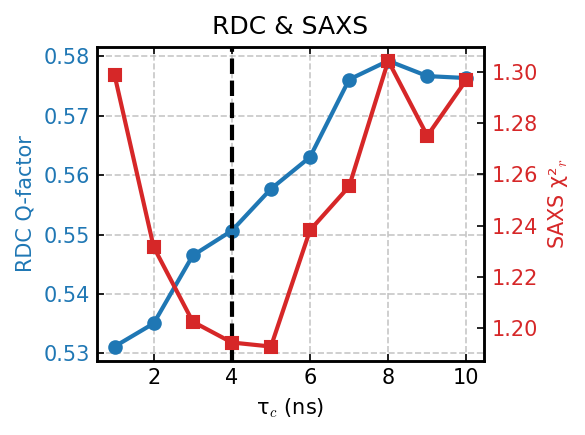

In [9]:
# check across tauc values, agreement with RDC and SAXS data at the optimal index
tauc_values = np.arange(1.0, 11.0, 1.0)


opt_rdc = []
opt_saxs = []
for tc in tauc_values:
    # Load data
    wopt_array = np.load(outpath+f'rew_wopt_array{tc}ns.npy')
    CS_RMSE = np.loadtxt(outpath+f'rew_CS_RMSE{tc}ns.txt')
    SAXS_chi2 = np.loadtxt(outpath+f'SAXS_chi2r_{tc}ns.txt')
    RDC_Q = np.loadtxt(outpath+f'RDC_Qfactors_{tc}ns.txt')
    PRE_RMSEs = np.loadtxt(outpath+f'rew_PRE_RMSE{tc}ns.txt')
    neffs = np.loadtxt(outpath+f'rew_neffs{tc}ns.txt')
    ESSs = np.array([np.sum(w)**2/np.sum(w**2) for w in wopt_array])

    # Find the last index where neffs > 0.2
    idx_opt = np.where(neffs > 0.2)[0][-1]

    opt_rdc.append(RDC_Q[idx_opt])
    opt_saxs.append(SAXS_chi2[idx_opt])

# ---------------------------------------
# Plot RDC & SAXS vs tau_c (twin y-axes)
# ---------------------------------------

fig, ax1 = plt.subplots(figsize=(4, 3))

# ---------------------------
# RDC (left y-axis)
# ---------------------------
ax1.plot(
    tauc_values, opt_rdc,
    'o-', color='tab:blue'
)
ax1.set_ylabel('RDC Q-factor', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ---------------------------
# SAXS (right y-axis)
# ---------------------------
ax2 = ax1.twinx()
ax2.plot(
    tauc_values, opt_saxs,
    's-', color='tab:red'
)
ax2.set_ylabel('SAXS χ²$_{r}$', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.grid(False)

# Vertical line at chosen tau_c
ax1.axvline(4.0, color='black', linestyle='dashed', linewidth=2)

# Labels & title (unchanged style)
ax1.set_xlabel('τ$_{c}$ (ns)')
ax1.set_title('RDC & SAXS')

plt.tight_layout()
plt.savefig(outpath + 'tauc_optimisation_BMErew_RDC_SAXS.pdf')



19
3093.7387222052353


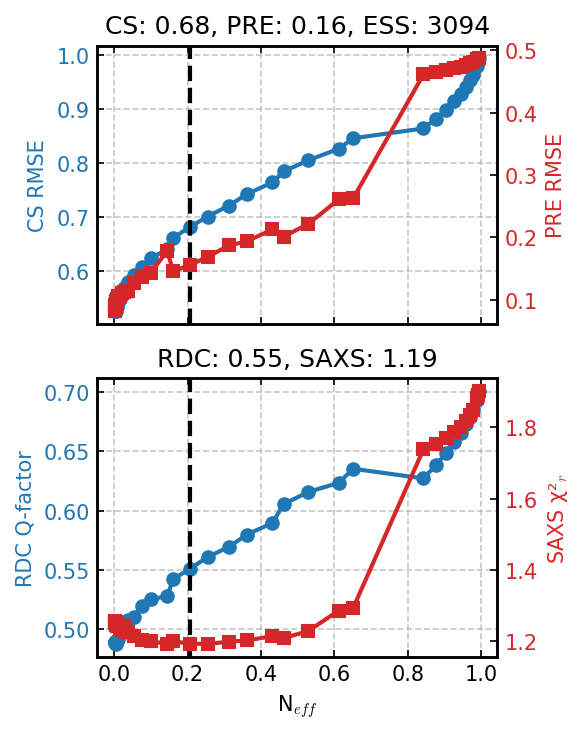

In [10]:
# plot agreement with active and validation data

tc = 4.0

# Load data
wopt_array = np.load(outpath+f'rew_wopt_array{tc}ns.npy')
CS_RMSE = np.loadtxt(outpath+f'rew_CS_RMSE{tc}ns.txt')
SAXS_chi2 = np.loadtxt(outpath+f'SAXS_chi2r_{tc}ns.txt')
RDC_Q = np.loadtxt(outpath+f'RDC_Qfactors_{tc}ns.txt')
PRE_RMSEs = np.loadtxt(outpath+f'rew_PRE_RMSE{tc}ns.txt')
neffs = np.loadtxt(outpath+f'rew_neffs{tc}ns.txt')
ESSs = np.array([np.sum(w)**2/np.sum(w**2) for w in wopt_array])

# Find the last index where neffs > 0.2
idx_opt = np.where(neffs > 0.2)[0][-1]
print(idx_opt)
print(ESSs[idx_opt])
# write optimal weights
np.savetxt(outpath+'CS_PRE_rew_weights.txt', wopt_array[idx_opt])

# Create figure with 2 stacked subplots sharing x-axis
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(4, 5), sharex=True)  # taller figure

# ---------------------------
# Top subplot: CS & PRE
# ---------------------------
ax1.plot(neffs, CS_RMSE, 'o-', label='CS', color='tab:blue')
ax1.set_ylabel('CS RMSE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(neffs, PRE_RMSEs, 's-', label='PRE', color='tab:red')
ax2.set_ylabel('PRE RMSE', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.grid(False)

ax1.axvline(neffs[idx_opt], color='black', linestyle='dashed')
ax1.set_title(f'CS: {CS_RMSE[idx_opt]:.2f}, PRE: {PRE_RMSEs[idx_opt]:.2f}, ESS: {ESSs[idx_opt]:.0f}')

# ---------------------------
# Bottom subplot: RDC & SAXS
# ---------------------------
ax3.plot(neffs, RDC_Q, 'o-', label='RDC', color='tab:blue')
ax3.set_xlabel('N$_{eff}$')
ax3.set_ylabel('RDC Q-factor', color='tab:blue')
ax3.tick_params(axis='y', labelcolor='tab:blue')

ax4 = ax3.twinx()
ax4.plot(neffs, SAXS_chi2, 's-', label='SAXS', color='tab:red')
ax4.set_ylabel('SAXS χ²$_{r}$', color='tab:red')
ax4.tick_params(axis='y', labelcolor='tab:red')
ax4.grid(False)

ax3.axvline(neffs[idx_opt], color='black', linestyle='dashed')
ax3.set_title(f'RDC: {RDC_Q[idx_opt]:.2f}, SAXS: {SAXS_chi2[idx_opt]:.2f}')

plt.tight_layout()
plt.savefig(outpath+'BMErew_all_data.pdf')


In [11]:
# ensemble-averaged rg (mass weighted)
protein = 'ACTR_REST2_300K_ensemble'

ntrajs=1
for i in range(ntrajs):
    if i==0:
        rg = np.loadtxt(data_path+f'{protein}/rg_data/rg_traj{i}.txt')
    else:
        tmprg = np.loadtxt(data_path+f'{protein}/rg_data/rg_traj{i}.txt')
        rg = np.concatenate((rg, tmprg), axis=0)
rg = rg[PREframes]
rg_prior = np.average(rg)
rg_posterior = np.average(rg, weights=wopt_array[idx_opt])

wmask = np.where(wopt_array[idx_opt]>0)[0]
rg = rg[wmask]



# errors
reblock_data = pyblock.blocking.reblock(rg)
opt = pyblock.blocking.find_optimal_block(len(rg), reblock_data)[0]
print(opt)
print(len(reblock_data))
err_prior = reblock_data[opt][4]

reblock_data = pyblock.blocking.reblock(rg, weights=wopt_array[idx_opt][wmask])
opt = pyblock.blocking.find_optimal_block(len(rg), reblock_data)[0]
print(opt)
print(len(reblock_data))
err_posterior = reblock_data[opt][4]

# save
df = pd.DataFrame()
df['Ensemble'] = ['prior', 'posterior']
df['Rg (nm)'] = np.round([rg_prior, rg_posterior], decimals=2)
df['±'] = np.round([err_prior, err_posterior], decimals=2)
df.to_csv(outpath+"rg_prior_posterior_massweighted.csv")
df

11
15
8
15


,Ensemble,Rg (nm),±
0,prior,2.05,0.04
1,posterior,2.34,0.03
